# BT4014 Final Project Code
Group 7

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Load packages and dataset
We will be using the Anime Recommendation Database 2020 from Kaggle.

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import pylab as plt
import math
from scipy.stats import beta
from tqdm.auto import tqdm
import itertools
from sklearn.utils import resample
np.random.seed(4014)

In [ ]:
# load datasets
animeRating = pd.read_csv("/content/drive/MyDrive/BT4014 Group 7/rating_complete.csv")
anime = pd.read_csv("/content/drive/MyDrive/BT4014 Group 7/anime.csv")
print(animeRating.shape)
print(anime.shape)

(57633278, 3)
(17562, 35)


## Exploratory Data Analysis
In this section, we will be analysing the distribution of the variables.

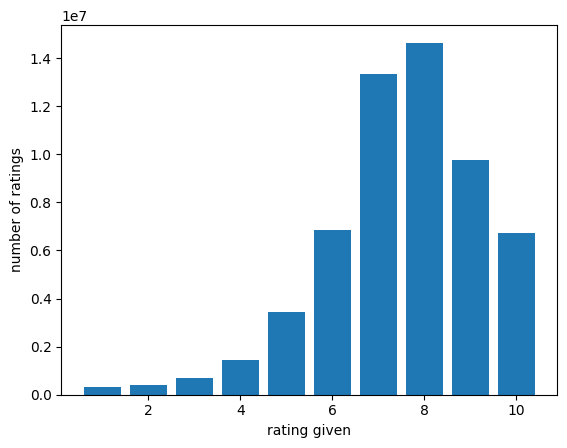

In [ ]:
# explore distribution of ratings 
plt.bar(animeRating['rating'].value_counts().index, animeRating['rating'].value_counts().values)
plt.xlabel('rating given')
plt.ylabel('number of ratings')
plt.show()

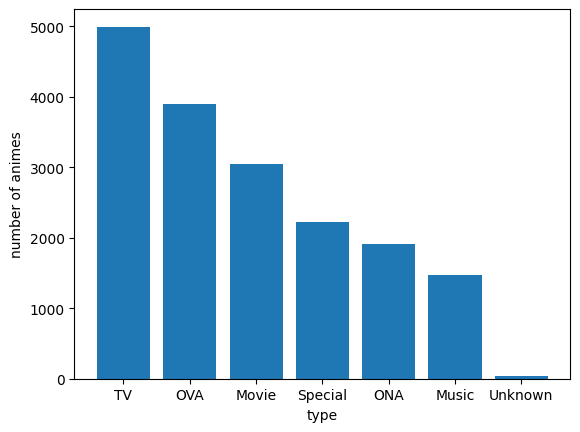

In [ ]:
# explore distribution of anime type 
plt.bar(anime['Type'].value_counts().index, anime['Type'].value_counts().values)
plt.xlabel('type')
plt.ylabel('number of animes')
plt.show()

In [ ]:
# filter tv shows only
anime = anime[anime['Type'] == 'TV'][['MAL_ID','Name','Genres']]

In [ ]:
# join two dataframes using anime id
selectedAnimes = anime.merge(animeRating, how = 'left', left_on = 'MAL_ID', right_on = 'anime_id').drop(columns=["MAL_ID"])

# generate sumary of animes based on (1) number of ratings given (2) average rating
selectedAnimes = selectedAnimes.groupby(['Name','anime_id']) \
        .agg(count=('user_id', 'size'), rating=('rating', 'mean')) \
        .sort_values(by='count', ascending=False) \
        .reset_index()

# get list of animes that have at least 100,000 ratings 
selectedAnimes = selectedAnimes[selectedAnimes['count'] > 100000] # there are 26 animes
selectedAnimes = selectedAnimes.set_index('Name')
selectedAnimes['anime_id'] = selectedAnimes['anime_id'].astype('int')

Text(0.5, 1.0, 'Animes with highest number of ratings')

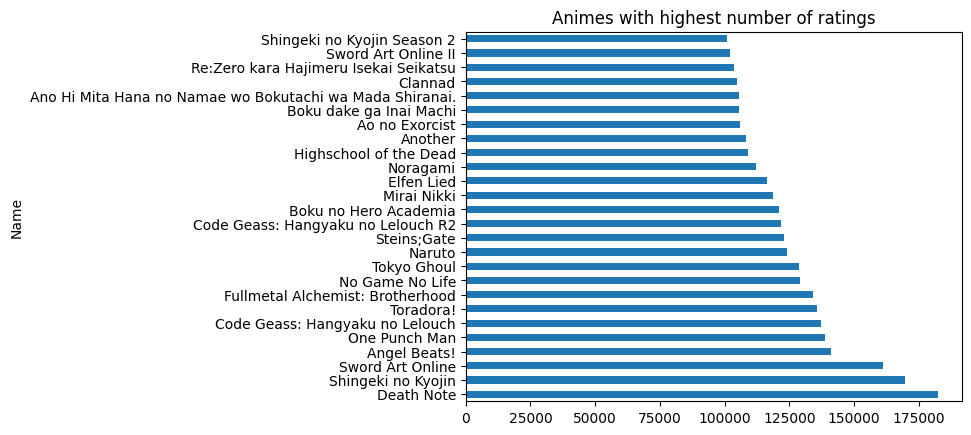

In [ ]:
# explore distribution of top 26 animes (by count)
selectedAnimes[['count']].plot(kind='barh')
plt.legend('', frameon=False) # remove legend
plt.title('Animes with highest number of ratings')

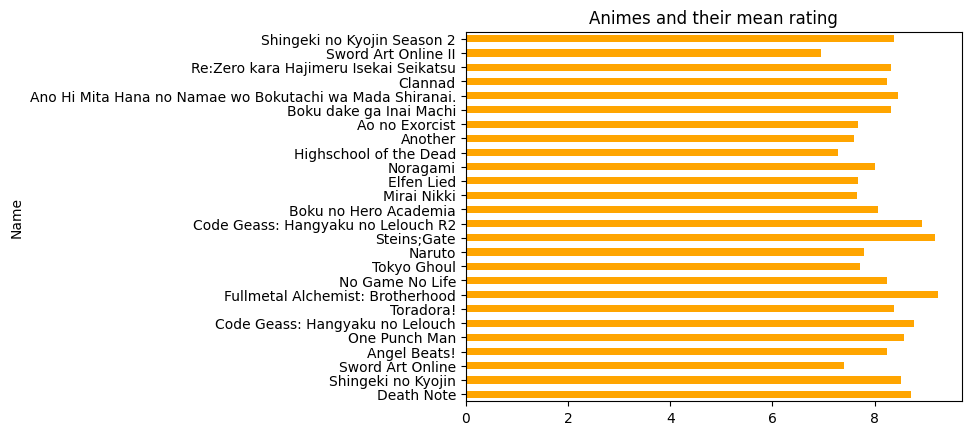

In [ ]:
# explore distribution of top 26 animes (by mean rating)
selectedAnimes[['rating']].plot(kind='barh', color='orange')
plt.title('Animes and their mean rating')
plt.legend('', frameon=False) # remove legend
plt.show()

## Data Preprocessing 
In this section, we will be preparing our data for the bandit algorithms.

In [ ]:
# create 'reward' column where 1 indicates rating above 7; 0 otherwise
animeRating['reward'] = np.where(animeRating['rating'] > 7, 1, 0) 
animeRating.head()

,user_id,anime_id,rating,reward
0,0,430,9,1
1,0,1004,5,0
2,0,3010,7,0
3,0,570,7,0
4,0,2762,9,1


In [ ]:
# filter animes that have more than 100,000 ratings
animeRatingFiltered = animeRating[animeRating['anime_id'].isin(selectedAnimes.anime_id)]
convert_dict = {'user_id': np.int32,
                'anime_id': np.int16,
                'rating': np.int8,
                'reward': np.int8} # chosen based on maximum value of each column
animeRatingFiltered = animeRatingFiltered.astype(convert_dict)
animeRatingFiltered.head()

,user_id,anime_id,rating,reward
52,1,20,10,1
61,1,6547,6,0
62,1,9919,8,1
64,1,31043,9,1
65,1,31964,9,1


In [ ]:
# aggregate all the animes that each user_id watches 
watched = animeRatingFiltered[['user_id', 'anime_id']].groupby('user_id').agg(pd.Series.tolist)
watched

,anime_id
user_id,
1,"[20, 6547, 9919, 31043, 31964, 1575, 5114, 153..."
2,"[10620, 20, 30276, 16498, 9253, 22319, 31964, ..."
3,"[9253, 4224, 20507, 19815, 31240, 30276, 226, ..."
4,"[4224, 1575, 2904, 1535]"
5,"[4224, 226]"
...,...
353396,"[9989, 4224, 22319, 31964, 1535, 5114, 25777, ..."
353398,"[20507, 30276, 31240, 20, 19815, 10620, 4224, ..."
353400,"[226, 31240, 11757, 30276, 20]"


In [ ]:
# convert anime dataset to dictionary, with anime_id as index and genre as keys
anime_by_genre = anime[['MAL_ID', 'Genres']].set_index('MAL_ID').to_dict()
anime_by_genre = anime_by_genre['Genres']
anime_by_genre

{1: 'Action, Adventure, Comedy, Drama, Sci-Fi, Space',
 6: 'Action, Sci-Fi, Adventure, Comedy, Drama, Shounen',
 7: 'Action, Mystery, Police, Supernatural, Drama, Magic',
 8: 'Adventure, Fantasy, Shounen, Supernatural',
 15: 'Action, Sports, Comedy, Shounen',
 16: 'Comedy, Drama, Josei, Romance, Slice of Life',
 17: 'Slice of Life, Comedy, Sports, Shounen',
 18: 'Action, Cars, Sports, Drama, Seinen',
 19: 'Drama, Horror, Mystery, Police, Psychological, Seinen, Thriller',
 20: 'Action, Adventure, Comedy, Super Power, Martial Arts, Shounen',
 21: 'Action, Adventure, Comedy, Super Power, Drama, Fantasy, Shounen',
 22: 'Action, Comedy, Sports, School, Shounen',
 23: 'Action, Shounen, Sports',
 24: 'Comedy, Romance, School, Shounen',
 25: 'Action, Adventure, Comedy, Ecchi, Sci-Fi, Shounen',
 26: 'Action, Sci-Fi, Psychological, Drama',
 27: 'Action, Supernatural, Vampire',
 28: 'Comedy, Shounen',
 29: 'Action, Military, Sci-Fi, Historical, Drama, Seinen',
 30: 'Action, Sci-Fi, Dementia, Psyc

In [ ]:
# function to retreive each user's preferred genre
def retrieveTopGenre(w: list):
    def flatten(list_of_lists):
        return list(itertools.chain.from_iterable(list_of_lists))
    genreCounts = pd.Series(flatten([x.split(", ") for x in w])).value_counts() # get count for each genre
    topGenre = genreCounts.index[genreCounts.argmax()] # preferred == most watched genre (highest count)
    return topGenre

user_prefer = pd.DataFrame(watched['anime_id'].apply(lambda x: [anime_by_genre[i] for i in x])) # get all genres watched by user
user_prefer['anime_id'] = user_prefer['anime_id'].apply(lambda x: retrieveTopGenre(x)) # get preferred genre for all users
user_prefer = user_prefer.to_dict()['anime_id'] # convert to dictionary
user_prefer # show each user's preferred genre

{1: 'Action',
 2: 'Action',
 3: 'Supernatural',
 4: 'School',
 5: 'Romance',
 6: 'Action',
 7: 'Action',
 8: 'Supernatural',
 11: 'Action',
 12: 'Action',
 13: 'Drama',
 14: 'Action',
 16: 'Action',
 17: 'Action',
 18: 'Supernatural',
 19: 'Action',
 20: 'Action',
 21: 'Action',
 23: 'Action',
 25: 'Drama',
 27: 'Action',
 28: 'Action',
 29: 'Action',
 30: 'Action',
 31: 'Slice of Life',
 32: 'Action',
 33: 'Comedy',
 34: 'Action',
 35: 'Action',
 36: 'Action',
 37: 'Action',
 38: 'Action',
 40: 'Action',
 41: 'Action',
 42: 'Supernatural',
 43: 'Mystery',
 44: 'Action',
 45: 'Romance',
 46: 'Action',
 47: 'Action',
 48: 'Shounen',
 49: 'Action',
 50: 'Action',
 51: 'Action',
 52: 'Action',
 53: 'Action',
 54: 'Action',
 55: 'Action',
 56: 'Action',
 57: 'Action',
 58: 'Supernatural',
 59: 'Action',
 61: 'Action',
 62: 'Supernatural',
 63: 'Action',
 64: 'Action',
 65: 'Mystery',
 66: 'Shounen',
 67: 'Action',
 68: 'Drama',
 70: 'Mystery',
 72: 'Action',
 73: 'Action',
 74: 'Action',
 

In [ ]:
# create dictionary for (genre:list of anime_id)
genre_list = set(", ".join(anime_by_genre.values()).split(", "))
genre_value = ([] for i in range(len(genre_list)))
genre_dict = dict(zip(genre_list, genre_value))

for anime_id in anime_by_genre.keys(): # loop through anime
  anime_genre = anime_by_genre[anime_id].split(", ") # get list of genres for current anime 
  for genre in anime_genre: # loop through genres of current anime
    genre_dict[genre].append(anime_id) # add anime_id to genre dict

genre_dict

{'Parody': [218,
  229,
  240,
  306,
  309,
  379,
  490,
  516,
  569,
  714,
  849,
  918,
  941,
  1196,
  1502,
  1738,
  1743,
  1769,
  1837,
  1865,
  1887,
  2026,
  2041,
  2104,
  2234,
  2280,
  2390,
  2508,
  2510,
  2605,
  3112,
  3136,
  3228,
  3229,
  3295,
  3418,
  3573,
  3619,
  4192,
  4382,
  4737,
  4908,
  4962,
  5005,
  5030,
  5343,
  5477,
  5909,
  6377,
  6582,
  6609,
  7175,
  7419,
  7769,
  8189,
  8215,
  8795,
  9493,
  9562,
  9624,
  9712,
  9969,
  10177,
  10324,
  10810,
  11785,
  12181,
  12611,
  12979,
  13207,
  13431,
  13503,
  13535,
  14653,
  15417,
  15699,
  15751,
  16157,
  16526,
  16982,
  17705,
  17707,
  18095,
  18241,
  18391,
  18465,
  18523,
  19121,
  19365,
  19369,
  19501,
  19919,
  20075,
  20125,
  20199,
  20603,
  21427,
  21433,
  21851,
  22755,
  22821,
  23607,
  23829,
  24041,
  24835,
  25999,
  27621,
  27727,
  28401,
  28835,
  28977,
  30276,
  30470,
  30782,
  30831,
  30851,
  31018,
  31174,
  3

## Algorithms
We explored 3 algorithms and compare their performances, they are epsilon decay, annealing softmax and thompson sampling.

In [ ]:
# function for selecting arms using adaptations for epsilon decay 
def epsilon_decay_policy(history, arms, user):
    epsilon = 1/(sum(history['count'])/ len(arms) + 1) # decay function for epsilon
    explore = np.random.binomial(1, epsilon) # randomly select between 1 and 0 with probability = epsilon
    
    if explore == 1 or history.shape[0] == 0: # explore
        preferred_genre = user_prefer[user] # get user's preferred genre
        rec = np.random.choice(genre_dict[preferred_genre], replace=False) # randomly select anime from preferred genre (uniform distribution)

    else: # exploit
        ranks = history.sort_values(by=['mean'], ascending=False) # choose arm with best mean reward (history)
        rec = ranks.iloc[0]['arm'] 
    
    return rec

In [ ]:
# function for selecting arms using annealing softmax
def annealing_softmax_policy(history, arms, user):
    tau = 1 / (sum(history['count']) / len(arms) + 1)
    MAX = max(history['mean'])/tau # to handle numerical overflow
    z = sum([np.exp(v/tau - MAX) for v in history['mean']])
    probs = [np.exp(v/tau - MAX)/z for v in history['mean']] # pi: calculate probability of arm
    rec = np.random.choice(arms, p = probs) # select arm 
    return rec

In [ ]:
# function for selecting arms using thompson sampling
def thompson_sampling_policy(history, arms, user):
    thetas = [np.random.beta(history['alpha'][x], history['beta'][x]) for x in range(len(arms))] # sample theta using beta distribution
    best_arm = max(range(len(arms)), key=lambda x: thetas[x]) # select arm with highest theta value
    rec = arms[best_arm]
    return rec

In [ ]:
# function for running offline evaluation using bootstrap samples for selected algo
def offlineEvaluate(algos, df, B):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------            
    algos : functions 
        Algorithm to be tested. Takes in (history, arms, user) and returns the selected arm.
    
    dfs : pandas DataFrame 
        Logged data containing two columns: anime_id, corresponding reward 
        
    B : int
        Number of bootstrap samples to be done
    
    Returns
    -------
    evaluation : pandas DataFrame
        Rewards for the matching events.

    play_stats : pandas DataFrame
        Record of logged events played in the algorithm
    """
    arms = df.anime_id.unique() # get unique anime ids
    k = df.anime_id.nunique() # get total number of arms, k
    t = df.shape[0] # size of logged dataframe

    # define a dataframe for evaluation results
    evaluation_cols = ['policy', 'time_step', 'chosen_arm', 'reward', 'round']
    evaluation = []

    # define a list to save all arm-play statistics
    play_stats = []

    for f in tqdm(algos, desc = 'ALGO'): # loop through algorithms 
        for b in tqdm(range(B), desc = 'sample'): # loop through B number of bootstrap samples
            # define a container to store all knowledge learnt for each arm
            container_cols = ['arm', 'sum', 'mean', 'count', 'alpha', 'beta']
            container = pd.DataFrame(data=None, columns=container_cols)
            container = container.astype({'arm': 'int32', 'sum': 'float', 'mean': 'float', 'count': 'float', 'alpha': 'float', 'beta': 'float'})

            # initialise container (history) values for each arm 
            for j in range(len(arms)):
                container.loc[j] = [arms[j], 0, 0, 0, 1, 1] # alpha and beta only applicable for thompson sampling, initailise with 1 (last two elements)

            step = 0
            boot = resample(df, replace = True, n_samples = t * k) # generate one bootstrap sample of the logged data with k*t size

            for i in tqdm(range(1,t+1)): # loop through bootstrap logged data
                user = boot.iloc[i-1]['user_id'] # get user_id from each row of logged data
                rec_a = f(container, arms, user) # select arm using algo ('user' parameter is used only for epsilon decay policy)

                # if recommendation matches record at step t
                if rec_a == boot.iloc[i-1]['anime_id']:
                    step = step + 1
                    action = boot.iloc[i-1]['anime_id'] # get action of matching step from logged data
                    reward = boot.iloc[i-1]['reward'] # get reward of matching step from logged data

                    # update evaluation dataframe 
                    eva_rec = {'policy' : f.__name__, 'log_step' : i, 'play_step' : step, 'chosen_arm' : action, 'reward' : reward}
                    evaluation.append(eva_rec)

                    # update container (history of arms) to update algo
                    container['count'] = np.where(container['arm'] == action, container['count'] + 1, container['count'])
                    container['sum'] = np.where(container['arm'] == action, container['sum'] + reward, container['sum'])
                    container['mean'] = np.where(container['arm'] == action, container['sum'] / (container['count'] + 0.0), container['mean'])

                    # update container (for thompson sampling algo only)
                    if f.__name__ == 'thompson_sampling_policy':
                        container['alpha'] = np.where(container['arm'] == action, container['alpha'] + reward, container['alpha'])
                        container['beta'] = np.where(container['arm'] == action, container['beta'] + (1 - reward), container['beta'])

                else: # fetch next row of logged data
                    continue

            container['policy'] = f.__name__ + str(b) # update policy name with the bootstrap sample num
            play_stats.append(container) # update play_stats
    return pd.DataFrame(evaluation), play_stats

In [ ]:
algos = [thompson_sampling_policy, annealing_softmax_policy, epsilon_decay_policy]

# summarize and sort results of bandits by pollicy and playstep
output = offlineEvaluate(algos, animeRatingFiltered, 3)
evaluation = output[0].sort_values(by = ['policy','play_step'])

# computing the evaluation metric for each algo
evaluation = evaluation.groupby(['policy','play_step'])[['reward']].mean().reset_index() # calculate average reward
evaluation['cumulative_rewards'] = evaluation.groupby(['policy'])['reward'].cumsum() # calculate cumulative reward
play_stats = pd.concat(output[1]) 

# save output to csv files
evaluation.to_csv("/content/drive/MyDrive/BT4014 Group 7/replay_evaluation.csv", index=False)
play_stats.to_csv("/content/drive/MyDrive/BT4014 Group 7/replay_stats.csv", index=False)
print(evaluation.shape)

ALGO:   0%|          | 0/3 [00:00<?, ?it/s]

sample:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3241075 [00:00<?, ?it/s]

  0%|          | 0/3241075 [00:00<?, ?it/s]

  0%|          | 0/3241075 [00:00<?, ?it/s]

sample:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3241075 [00:00<?, ?it/s]

  0%|          | 0/3241075 [00:00<?, ?it/s]

  0%|          | 0/3241075 [00:00<?, ?it/s]

sample:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3241075 [00:00<?, ?it/s]

  0%|          | 0/3241075 [00:00<?, ?it/s]

  0%|          | 0/3241075 [00:00<?, ?it/s]

(406591, 4)


### Evaluation

In [ ]:
evaluation

,policy,play_step,reward,cumulative_rewards
0,annealing_softmax_policy,1,0.333333,0.333333
1,annealing_softmax_policy,2,1.000000,1.333333
2,annealing_softmax_policy,3,0.666667,2.000000
3,annealing_softmax_policy,4,0.666667,2.666667
4,annealing_softmax_policy,5,0.666667,3.333333
...,...,...,...,...
406586,thompson_sampling_policy,134722,1.000000,126563.500000
406587,thompson_sampling_policy,134723,1.000000,126564.500000
406588,thompson_sampling_policy,134724,1.000000,126565.500000
406589,thompson_sampling_policy,134725,1.000000,126566.500000


In [ ]:
play_stats

,arm,sum,mean,count,alpha,beta,policy
0,20,6,0.500000,12,7,7,thompson_sampling_policy0
1,6547,28,0.756757,37,29,10,thompson_sampling_policy0
2,9919,16,0.727273,22,17,7,thompson_sampling_policy0
3,31043,25,0.714286,35,26,11,thompson_sampling_policy0
4,31964,14,0.636364,22,15,9,thompson_sampling_policy0
...,...,...,...,...,...,...,...
21,8074,0,0.000000,1,1,1,epsilon_decay_policy2
22,20507,4,0.800000,5,1,1,epsilon_decay_policy2
23,2167,3,0.750000,4,1,1,epsilon_decay_policy2
24,11111,0,0.000000,0,1,1,epsilon_decay_policy2


In [ ]:
evaluation['rolling_mean'] = evaluation.groupby('policy')['reward'].transform(lambda x: x.rolling(200).mean())

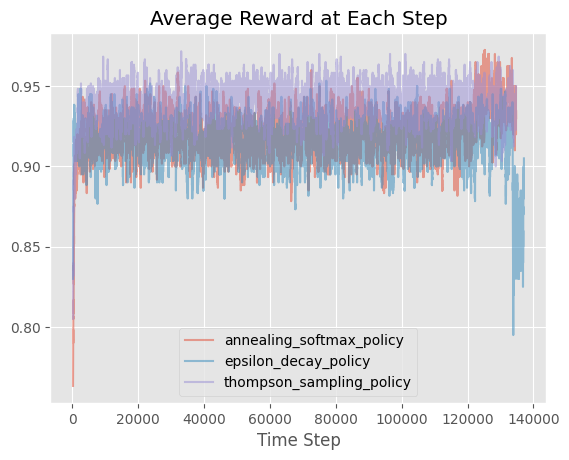

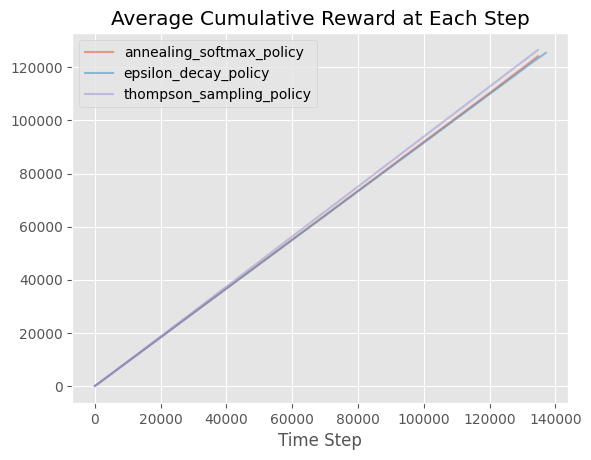

In [ ]:
# reward analysis
plt.style.use('ggplot')

# plot for average rewards
fig = plt.figure()
ax = fig.add_subplot(111)
for pol in evaluation['policy'].unique():
  ax.plot(evaluation[evaluation['policy'] == pol]['play_step'], evaluation[evaluation['policy'] == pol]['rolling_mean'], alpha=0.5, label=str(pol))
plt.legend()
plt.title('Average Reward at Each Step')
plt.xlabel('Time Step')

# plot for cumulative rewards
fig = plt.figure()
ax1 = fig.add_subplot(111)
for pol in evaluation['policy'].unique():
  ax1.plot(evaluation[evaluation['policy'] == pol]['play_step'], evaluation[evaluation['policy'] == pol]['cumulative_rewards'], alpha=0.5, label=str(pol))
plt.legend()
plt.title('Average Cumulative Reward at Each Step')
plt.xlabel('Time Step')
plt.show()

In [ ]:
evaluation[evaluation['policy'] == 'thompson_sampling_policy']['cumulative_rewards']

271865         1.000000
271866         2.000000
271867         2.666667
271868         3.666667
271869         4.666667
              ...      
406586    126563.500000
406587    126564.500000
406588    126565.500000
406589    126566.500000
406590    126567.500000
Name: cumulative_rewards, Length: 134726, dtype: float64

In [ ]:
evaluation[evaluation['policy'] == 'annealing_softmax_policy']['cumulative_rewards']

0              0.333333
1              1.333333
2              2.000000
3              2.666667
4              3.333333
              ...      
134744    124181.500000
134745    124182.500000
134746    124183.500000
134747    124184.500000
134748    124184.500000
Name: cumulative_rewards, Length: 134749, dtype: float64

In [ ]:
evaluation[evaluation['policy'] == 'epsilon_decay_policy']['cumulative_rewards']

134749         0.333333
134750         1.333333
134751         2.000000
134752         2.666667
134753         3.333333
              ...      
271860    125432.333333
271861    125433.333333
271862    125434.333333
271863    125435.333333
271864    125436.333333
Name: cumulative_rewards, Length: 137116, dtype: float64